In [1]:
pip install tensorflow

  Using cached tensorflow-2.8.0-cp38-cp38-win_amd64.whl (438.0 MB)
Note: you may need to restart the kernel to use updated packages.Collecting astunparse>=1.6.0

  Using cached cachetools-5.0.0-py3-none-any.whl (9.1 kB)
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=e5769018c053dca72c17766e3c7e0e15731b79484ea2339f29018cf699d9bec7
  Stored in directory: c:\users\ameyb\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.0
    Uninstalling importlib-metadata-3.10.0:
      Successfully uninstalled importlib-metadata-3.10.0


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format= '[%(asctime)s] %(levelname)s: %(message)s')

# Task IV - Classical Graph Neural Network (GNN) Part

## Problem Statement
For Task IV, you will use ParticleNet’s data for Quark/Gluon jet classification available here with its corresponding description.

● Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges.

● Discuss the resulting performance of the 2 chosen architectures.

## Dataset

The dataset used in this project was actually used in <i> P. T. Komiske, E. M. Metodiev, J. Thaler, Energy Flow Networks: Deep Sets for Particle Jets, JHEP 01 (2019) 121, arXiv:1810.05165.</i><br>
It has 20 files consisting of jet data with each file having 100k samples.There are two arrays in each file
<ul><li>    
X: (100000,M,4), exactly 50k quark and 50k gluon jets, randomly sorted, where M is the max multiplicity of the jets in that file (other jets have been padded with zero-particles), and the features of each particle are its pt, rapidity, azimuthal angle, and pdgid.
</li>
<li>     
y: (100000,), an array of labels for the jets where gluon is 0 and quark is 1.
</li>
</ul>

#### <i>However due to hardware limitations, we use only the first file of the complete dataset i.e. 100k total samples of data in this project.</i>

## Architecture & Approach

A jet is one of the most ubiquitous objects in proton-proton collision events at the LHC. In essence, a jet is
a collimated spray of particles. In this task, the jet data is represented as a particle cloud analogous to the point cloud representation of 3D shapes used in computer vision. The permutation symmetry of the particle cloud makes it a natural and promising representation of jets.


<br>
I studied the following Graph-based architectures:<br>

### <i>1. ABCNet</i>

### <i>2. ParticleNet  </i>                     

### <i>3. ParticleNet Lite </i>

### <i>4. Message Passing Neural Networks </i>

### Important Points
<ul>
    <li>ABCNet[3] is an attention based features update approach which also consists of a GAPLayer(Graph attention pooling layer)
    that transforms the feature vectors to a higher dimensional space and passes to the attention layer with attention coefficients.This is helpful for quark gluon tagging because the attention mechanism considers the local features required for better classification performance</li>
    <li>ParticleNet and PartcileNet Lite have fundamentally similar architectures that use the power of EdgeConv to parameterize over local dependencies in the point-cloud representation and give better results that most other approaches.</li>
    <li>Message Passing Neural Nets[4] uses Adjacency learning which is particularly important in applications where the input set may have some underlying geometric structure and hence can serve the purpose for quark gluon classification</li>
</ul><br>
<br>
After studying all of the above architectures briefly, it is evident that if the necessary computing resources are available, then ABCNet performs best with over 230k features(considerably less than ParticeNet ~360k features) because it uses an extra power of attention mechanisms.Message Passing Nets are a good option but they consider the structure to be permutation equivariant which affects classification performance. ParticleNet is a better option because it handles large unordered data efficiently considering permutation invariance between datapoints and techniques like EdgeConv(a permutationally symmetric operation on point
clouds) <br>

However, all the above architectures require heavy computing resources due to the high number of features they use for training.

### Project Approach
<i> ParticleNet</i>, a CNN-like deep neural network architecture is used for jet tagging with particle cloud data.<br>
This project will follow mainly the reference [2] but with some changes to explore things that is not yet explored in the paper.<br><br>
However,regular CNNs are suitable for data with some uniform grid like ordering of images, while the particle cloud is an unordered, permutation invariant representation. <i>EdgeConv</i>, another convolution-like operation that exploits the local  neighbourhood information based on the k-nearest neighbouring particles for a particular particle is a good fit for point cloud data.
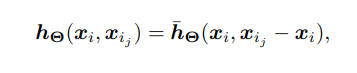

where the feature vectors of the neighbors, xij , are substituted by their differences from the central point xi and h¯Θ can be implemented as a multilayer perceptron(MLP) whose parameters are shared among all edges.
<br>
An important thing to note is that ParticleNet uses DGCNN(Dynamic Graph Convolutional Neural Network), the word 'dynamic' here denotes that the EdgeConv operation maps a point cloud datapoint from original feature space to another latent space and updates the co-ordinates according to latent space which are then used in calculating the k-nearest neighbour distances[1].In other words, the proximity of points can be dynamically learned with EdgeConv operations. Due to this, the graph describing the point clouds are dynamically updated to reflect the changes in the edges, i.e., the neighbors of each point.
### Single EdgeConv block
<img src="./edgeconv.png"><br>
 
### This project implements two architectures :
<!--  
ParticleNet consists of three EdgeConv blocks. The first EdgeConv block uses the spatial coordinates of the particles in the pseudorapidity-azimuth space to compute the distances, while the subsequent blocks use the learned feature vectors as coordinates. -->


## <i>1. ParticleNet Lite (Dynamic)</i>
<img src="./ParticleNet_Lite.png"><br>
ParticleNet Lite consists of three EdgeConv blocks with hyperparameter-values less than that are used in ParticleNet.The first EdgeConv block uses the spatial coordinates of the particles in the pseudorapidity-azimuth space to compute the distances, while the subsequent blocks use the learned feature vectors as coordinates.
<br>
## <i>2. ParticleNet Lite (Static)</i>
This architecture is exactly the same as the dynamic ParticleNet Lite except the fact that there is no dynamic update of the co-ordinates of particles based on the learned feature vectors, i.e the co-ordinates are always in the pseudorapidity-azimuth space to compute the distances between them.<br>

Both networks use a global average pooling for aggregating over the values obtained from the EdgeConv blocks along with a fully connected network with 2 units and output layer with a softmax function.<br><br>
#### Hyperparameters
The hyperparameters used are kept the same as implemented in the reference[2]<br>
<ul>
<li>k in k- nearest neighbours' distance measure:<br>
<!-- For ParticleNet, k=16<br> -->
For both archectures, k=7<br></li>
<li>
Also, the channels per layer for both architectures:<br>
<!-- For ParticleNet, for each EdgeConv block is (64, 64,64), (128, 128, 128), and (256, 256, 256), respectively.<br> -->
    for each EdgeConv block is (32, 32, 32), (64, 64, 64), respectively.<br>
</li>
<li>The LR(learning rate) schedule is described later in the form of code.</li></ul>

## Loading and prepocessing the dataset

In [2]:
def data_preprocess(data_1,data_2,label_1,label_2):
    if(data_1.shape[1] != data_2.shape[1]):
        if(data_1.shape[1]>data_2.shape[1]):
            data_2=np.concatenate((data_2,np.zeros((data_2.shape[0],data_1.shape[1]-data_2.shape[1],data_2.shape[2]))),axis=1)
        if(data_2.shape[1]>data_1.shape[1]):
            data_1=np.concatenate((data_1,np.zeros((data_1.shape[0],data_2.shape[1]-data_1.shape[1],data_1.shape[2]))) ,axis=1)
            
    dataset_X = np.concatenate((data_1,data_2), axis=0)
    dataset_y = np.concatenate((label_1,label_2), axis=0)
    
    return dataset_X,dataset_y


data = np.load('./GSOC22_QMLHEP_task_dataset/QG_jets.npz',allow_pickle=True)
X_train = data['X']
y_train = data['y']
# for i in range(1):
#     data_temp = np.load('./GSOC22_QMLHEP_task_dataset/QG_jets_' + str(i+1) + '.npz', allow_pickle=True)
#     print('file '+str(i+1)+' is loaded')
#     X_temp=data_temp['X']
#     y_temp=data_temp['y']
#     X_train,y_train = data_preprocess(X_train,X_temp,y_train,y_temp)
#Transform the labels to one-hot format
y_train = tf.keras.utils.to_categorical(y_train)

In [3]:
#check
print(X_train.shape)
# X_train.shape[0] = Number of training examples
# X_train.shape[1] = Maximum number of particles in a jet
# X_train.shape[2] = Total number of features
print(y_train.shape)

(100000, 139, 4)
(100000, 2)


In [4]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# Splitting the dataset into three parts- 80% training data, 10% validation data, 10% test data
X_train,y_train = shuffle(X_train, y_train, random_state=1024)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=1024)
X_val,X_test,y_val,y_test= train_test_split(X_val,y_val,test_size=0.5,random_state=1024)

num_particles = X_train.shape[1]
#check
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)

(80000, 139, 4)
(10000, 139, 4)
(10000, 139, 4)
(80000, 2)


In [5]:
train_dict = {
    #the co-ordinates of particles in (rapidity, azimuthal angle) space
    'points' : X_train[:,:,1:3],
    #the features of each particle are its pt, rapidity, azimuthal angle
    'features' : X_train,
    # a mask array, taking a value of 0 for padded positions (shape=num_samples,num_particles,1)
    'mask': np.sum(X_train, axis=2).reshape(len(X_train), num_particles, 1)
    }

val_dict = {
    #the co-ordinates of particles in (rapidity, azimuthal angle) space
    'points' : X_val[:,:,1:3],
    #the features of each particle are its pt, rapidity, azimuthal angle
    'features' : X_val,
    # a mask array, taking a value of 0 for padded positions (shape=num_samples,num_particles,1)
    'mask': np.sum(X_val, axis=2).reshape(len(X_val), num_particles, 1)
    }

test_dict = {
    #the co-ordinates of particles in (rapidity, azimuthal angle) space
    'points' : X_test[:,:,1:3],
    #the features of each particle are its pt, rapidity, azimuthal angle
    'features' : X_test,
    # a mask array, taking a value of 0 for padded positions (shape=num_samples,num_particles,1)
    'mask': np.sum(X_test, axis=2).reshape(len(X_test), num_particles, 1)
    }

# Initializing the Models

In [7]:
from tensorflow import keras
from tf_keras_model import get_particle_net_lite
from tf_keras_model_static import get_particle_net_lite_static

In [8]:
num_classes = 2
input_shapes = {k:train_dict[k].shape[1:] for k in train_dict}
print(input_shapes)

{'points': (139, 2), 'features': (139, 4), 'mask': (139, 1)}


In [9]:
model_lite_static = get_particle_net_lite_static(num_classes,input_shapes)
model_lite = get_particle_net_lite(num_classes,input_shapes)

### Hyperparameters

In [10]:
batch_size = 300
batch_size_lite = 1200

epochs = 20

In [11]:
# learning rate schedule
def lr_schedule(epochs):
    learning_rate = 0.001
    if epochs>9:
        learning_rate*=0.1
    if epochs>18:
        learning_rate*=0.01
    logging.info('Learning rate: %f'%learning_rate)
    return learning_rate

# I. ParticleNet Lite model (Dynamic)

In [25]:
model_lite.compile(loss = 'categorical_crossentropy',
             optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
             metrics=['accuracy',tf.keras.metrics.AUC()])
model_lite.summary()

[2022-04-01 14:05:47,115] INFO: Learning rate: 0.001000


Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 139, 1)]     0           []                               
                                                                                                  
 tf.math.not_equal_1 (TFOpLambd  (None, 139, 1)      0           ['mask[0][0]']                   
 a)                                                                                               
                                                                                                  
 tf.cast_2 (TFOpLambda)         (None, 139, 1)       0           ['tf.math.not_equal_1[0][0]']    
                                                                                                  
 tf.math.equal_1 (TFOpLambda)   (None, 139, 1)       0           ['tf.cast_2[0][0]']    

 tf.__operators__.getitem_3 (Sl  (None, 139, 7)      0           ['tf.math.top_k_1[0][1]']        
 icingOpLambda)                                                                                   
                                                                                                  
 tf.tile_4 (TFOpLambda)         (None, 139, 7, 1)    0           ['tf.reshape_2[0][0]']           
                                                                                                  
 tf.expand_dims_8 (TFOpLambda)  (None, 139, 7, 1)    0           ['tf.__operators__.getitem_3[0][0
                                                                 ]']                              
                                                                                                  
 tf.expand_dims_9 (TFOpLambda)  (None, 139, 1, 4)    0           ['tf.compat.v1.squeeze_3[0][0]'] 
                                                                                                  
 tf.concat

                                                                 ]                                
                                                                                                  
 tf.math.multiply_10 (TFOpLambd  (None, 139, 32)     0           ['tf.math.add_3[0][0]',          
 a)                                                               'tf.math.add_3[0][0]']          
                                                                                                  
 tf.math.reduce_sum_4 (TFOpLamb  (None, 139, 1)      0           ['tf.math.multiply_9[0][0]']     
 da)                                                                                              
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 139, 139)    0           ['tf.linalg.matmul_2[0][0]']     
 a)                                                                                               
          

                                                                                                  
 ParticleNet_EdgeConv1_act1 (Ac  (None, 139, 7, 64)  0           ['ParticleNet_EdgeConv1_bn1[0][0]
 tivation)                                                       ']                               
                                                                                                  
 tf.expand_dims_13 (TFOpLambda)  (None, 139, 1, 32)  0           ['ParticleNet_EdgeConv0_sc_act[0]
                                                                 [0]']                            
                                                                                                  
 ParticleNet_EdgeConv1_conv2 (C  (None, 139, 7, 64)  4096        ['ParticleNet_EdgeConv1_act1[0][0
 onv2D)                                                          ]']                              
                                                                                                  
 ParticleN

In [26]:
lr_scheduler=keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks=[lr_scheduler,progress_bar]
print(train_dict['points'].shape)
print(train_dict['features'].shape)
print(train_dict['mask'].shape)

(80000, 139, 2)
(80000, 139, 4)
(80000, 139, 1)


## Training the model

In [27]:
history_dynamic = model_lite.fit(train_dict,
                   y_train, 
                   epochs=epochs,
                   batch_size=batch_size,
                   callbacks=callbacks,
                   validation_data=(val_dict,y_val),
                   shuffle=True)

[2022-04-01 14:05:59,468] INFO: Learning rate: 0.001000


Epoch 1/20
267/267 [==============================] - 349s 1s/sample - loss: 0.5004 - accuracy: 0.7605 - auc_2: 0.8368 - val_loss: 0.5141 - val_accuracy: 0.7450 - val_auc_2: 0.8238 - lr: 0.0010


[2022-04-01 14:11:48,796] INFO: Learning rate: 0.001000


Epoch 2/20
267/267 [==============================] - 409s 2s/sample - loss: 0.4690 - accuracy: 0.7853 - auc_2: 0.8594 - val_loss: 0.4595 - val_accuracy: 0.7928 - val_auc_2: 0.8658 - lr: 0.0010


[2022-04-01 14:18:37,697] INFO: Learning rate: 0.001000


Epoch 3/20
267/267 [==============================] - 502s 2s/sample - loss: 0.4560 - accuracy: 0.7944 - auc_2: 0.8678 - val_loss: 0.4465 - val_accuracy: 0.8006 - val_auc_2: 0.8743 - lr: 0.0010


[2022-04-01 14:26:59,344] INFO: Learning rate: 0.001000


Epoch 4/20
267/267 [==============================] - 412s 2s/sample - loss: 0.4510 - accuracy: 0.7972 - auc_2: 0.8709 - val_loss: 0.4693 - val_accuracy: 0.7891 - val_auc_2: 0.8599 - lr: 0.0010


[2022-04-01 14:33:51,681] INFO: Learning rate: 0.001000


Epoch 5/20
267/267 [==============================] - 413s 2s/sample - loss: 0.4451 - accuracy: 0.8009 - auc_2: 0.8747 - val_loss: 0.4533 - val_accuracy: 0.7976 - val_auc_2: 0.8705 - lr: 0.0010


[2022-04-01 14:40:44,323] INFO: Learning rate: 0.001000


Epoch 6/20
267/267 [==============================] - 368s 1s/sample - loss: 0.4399 - accuracy: 0.8029 - auc_2: 0.8779 - val_loss: 0.4498 - val_accuracy: 0.7977 - val_auc_2: 0.8742 - lr: 0.0010


[2022-04-01 14:46:51,990] INFO: Learning rate: 0.001000


Epoch 7/20
267/267 [==============================] - 301s 1s/sample - loss: 0.4368 - accuracy: 0.8047 - auc_2: 0.8798 - val_loss: 0.4385 - val_accuracy: 0.8051 - val_auc_2: 0.8791 - lr: 0.0010


[2022-04-01 14:51:52,885] INFO: Learning rate: 0.001000


Epoch 8/20
267/267 [==============================] - 307s 1s/sample - loss: 0.4338 - accuracy: 0.8072 - auc_2: 0.8816 - val_loss: 0.4372 - val_accuracy: 0.8028 - val_auc_2: 0.8801 - lr: 0.0010


[2022-04-01 14:56:59,824] INFO: Learning rate: 0.001000


Epoch 9/20
267/267 [==============================] - 315s 1s/sample - loss: 0.4306 - accuracy: 0.8083 - auc_2: 0.8835 - val_loss: 0.4344 - val_accuracy: 0.8050 - val_auc_2: 0.8816 - lr: 0.0010


[2022-04-01 15:02:14,858] INFO: Learning rate: 0.001000


Epoch 10/20
267/267 [==============================] - 358s 1s/sample - loss: 0.4295 - accuracy: 0.8089 - auc_2: 0.8842 - val_loss: 0.4326 - val_accuracy: 0.8068 - val_auc_2: 0.8826 - lr: 0.0010


[2022-04-01 15:08:12,446] INFO: Learning rate: 0.000100


Epoch 11/20
267/267 [==============================] - 412s 2s/sample - loss: 0.4221 - accuracy: 0.8131 - auc_2: 0.8884 - val_loss: 0.4309 - val_accuracy: 0.8067 - val_auc_2: 0.8839 - lr: 1.0000e-04


[2022-04-01 15:15:04,488] INFO: Learning rate: 0.000100


Epoch 12/20
267/267 [==============================] - 513s 2s/sample - loss: 0.4207 - accuracy: 0.8135 - auc_2: 0.8892 - val_loss: 0.4279 - val_accuracy: 0.8083 - val_auc_2: 0.8853 - lr: 1.0000e-04


[2022-04-01 15:23:37,725] INFO: Learning rate: 0.000100


Epoch 13/20
267/267 [==============================] - 415s 2s/sample - loss: 0.4203 - accuracy: 0.8136 - auc_2: 0.8895 - val_loss: 0.4280 - val_accuracy: 0.8073 - val_auc_2: 0.8853 - lr: 1.0000e-04


[2022-04-01 15:30:32,520] INFO: Learning rate: 0.000100


Epoch 14/20
267/267 [==============================] - 415s 2s/sample - loss: 0.4200 - accuracy: 0.8143 - auc_2: 0.8896 - val_loss: 0.4270 - val_accuracy: 0.8084 - val_auc_2: 0.8858 - lr: 1.0000e-04


[2022-04-01 15:37:27,851] INFO: Learning rate: 0.000100


Epoch 15/20
267/267 [==============================] - 414s 2s/sample - loss: 0.4195 - accuracy: 0.8142 - auc_2: 0.8899 - val_loss: 0.4285 - val_accuracy: 0.8080 - val_auc_2: 0.8852 - lr: 1.0000e-04


[2022-04-01 15:44:21,403] INFO: Learning rate: 0.000100


Epoch 16/20
267/267 [==============================] - 418s 2s/sample - loss: 0.4189 - accuracy: 0.8146 - auc_2: 0.8902 - val_loss: 0.4270 - val_accuracy: 0.8084 - val_auc_2: 0.8857 - lr: 1.0000e-04


[2022-04-01 15:51:19,309] INFO: Learning rate: 0.000100


Epoch 17/20
267/267 [==============================] - 338s 1s/sample - loss: 0.4184 - accuracy: 0.8145 - auc_2: 0.8905 - val_loss: 0.4273 - val_accuracy: 0.8084 - val_auc_2: 0.8857 - lr: 1.0000e-04


[2022-04-01 15:56:57,270] INFO: Learning rate: 0.000100


Epoch 18/20
267/267 [==============================] - 324s 1s/sample - loss: 0.4177 - accuracy: 0.8152 - auc_2: 0.8909 - val_loss: 0.4265 - val_accuracy: 0.8080 - val_auc_2: 0.8861 - lr: 1.0000e-04


[2022-04-01 16:02:21,348] INFO: Learning rate: 0.000100


Epoch 19/20
267/267 [==============================] - 330s 1s/sample - loss: 0.4177 - accuracy: 0.8146 - auc_2: 0.8909 - val_loss: 0.4274 - val_accuracy: 0.8082 - val_auc_2: 0.8857 - lr: 1.0000e-04


[2022-04-01 16:07:51,078] INFO: Learning rate: 0.000001


Epoch 20/20
267/267 [==============================] - 418s 2s/sample - loss: 0.4175 - accuracy: 0.8153 - auc_2: 0.8910 - val_loss: 0.4264 - val_accuracy: 0.8095 - val_auc_2: 0.8862 - lr: 1.0000e-06


In [ ]:
#  import csv

# w = csv.writer(open("./train_history_dgcnn.csv", "w"))
# for key, val in history_dynamic.history.items():
#     w.writerow([key, val])

## AUC

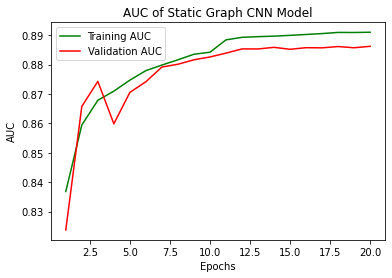

In [38]:
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dynamic.history['auc_2'], color='green', label='Training AUC')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dynamic.history['val_auc_2'], color='red', label='Validation AUC')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title("AUC of Static Graph CNN Model")
plt.legend()
plt.show()

## Accuracy

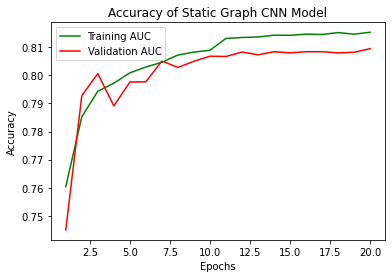

In [37]:
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dynamic.history['accuracy'], color='green', label='Training AUC')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dynamic.history['val_accuracy'], color='red', label='Validation AUC')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy of Static Graph CNN Model")
plt.legend()
plt.show()

## Loss

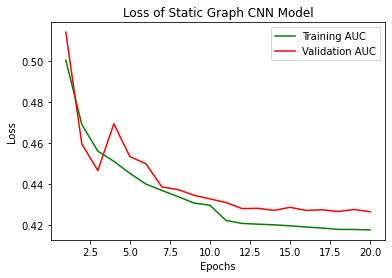

In [36]:
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dynamic.history['loss'], color='green', label='Training AUC')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dynamic.history['val_loss'], color='red', label='Validation AUC')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss of Static Graph CNN Model")
plt.legend()
plt.show()

## Evaluation 

In [35]:
loss, acc, auc = model_lite.evaluate(test_dict, y_test)
print("Evaluation Metric of Dynamic Graph CNN Model on Test Dataset")
print("Loss:", loss)
print("Accuracy:", acc)
print("AUC:", auc)


313/313 [==============================] - 16s 51ms/step - loss: 0.4262 - accuracy: 0.8119 - auc_2: 0.8859
Evaluation Metric of Dynamic Graph CNN Model on Test Dataset
Loss: 0.42618003487586975
Accuracy: 0.8119000196456909
AUC: 0.8858910799026489


## II. ParticleNet Lite model (static)

In [12]:
model_lite_static.compile(loss = 'categorical_crossentropy',
             optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
             metrics=['accuracy',tf.keras.metrics.AUC()])
model_lite_static.summary()

[2022-04-01 11:44:38,143] INFO: Learning rate: 0.001000


Model: "ParticleNet_Lite_Static"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 139, 1)]     0           []                               
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 139, 1)      0           ['mask[0][0]']                   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 139, 1)       0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.math.equal (TFOpLambda)     (None, 139, 1)       0           ['tf.cast[0][0]']                
                                                                            

                                                                                                  
 tf.expand_dims_1 (TFOpLambda)  (None, 139, 7, 1)    0           ['tf.__operators__.getitem[0][0]'
                                                                 ]                                
                                                                                                  
 tf.expand_dims_2 (TFOpLambda)  (None, 139, 1, 4)    0           ['tf.compat.v1.squeeze[0][0]']   
                                                                                                  
 tf.concat (TFOpLambda)         (None, 139, 7, 2)    0           ['tf.tile[0][0]',                
                                                                  'tf.expand_dims_1[0][0]']       
                                                                                                  
 tf.tile_1 (TFOpLambda)         (None, 139, 7, 4)    0           ['tf.expand_dims_2[0][0]']       
          

 tf.expand_dims_5 (TFOpLambda)  (None, 139, 1, 32)   0           ['ParticleNet_EdgeConv0_sc_act[0]
                                                                 [0]']                            
                                                                                                  
 tf.concat_2 (TFOpLambda)       (None, 139, 7, 2)    0           ['tf.tile_2[0][0]',              
                                                                  'tf.expand_dims_4[0][0]']       
                                                                                                  
 tf.tile_3 (TFOpLambda)         (None, 139, 7, 32)   0           ['tf.expand_dims_5[0][0]']       
                                                                                                  
 tf.compat.v1.gather_nd_1 (TFOp  (None, 139, 7, 32)  0           ['ParticleNet_EdgeConv0_sc_act[0]
 Lambda)                                                         [0]',                            
          

In [13]:
lr_scheduler=keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks=[lr_scheduler,progress_bar]
print(train_dict['points'].shape)
print(train_dict['features'].shape)
print(train_dict['mask'].shape)

(80000, 139, 2)
(80000, 139, 4)
(80000, 139, 1)


### Training the model

In [15]:
history = model_lite_static.fit(train_dict,
                   y_train, 
                   epochs=epochs,
                   batch_size=batch_size,
                   callbacks=callbacks,
                   validation_data=(val_dict,y_val),
                   shuffle=True)

[2022-04-01 11:46:06,009] INFO: Learning rate: 0.001000


Epoch 1/20
267/267 [==============================] - 616s 2s/sample - loss: 0.4911 - accuracy: 0.7719 - auc: 0.8450 - val_loss: 0.4635 - val_accuracy: 0.7893 - val_auc: 0.8638 - lr: 0.0010


[2022-04-01 11:56:22,299] INFO: Learning rate: 0.001000


Epoch 2/20
267/267 [==============================] - 410s 2s/sample - loss: 0.4569 - accuracy: 0.7961 - auc: 0.8675 - val_loss: 0.4491 - val_accuracy: 0.8012 - val_auc: 0.8724 - lr: 0.0010


[2022-04-01 12:03:12,336] INFO: Learning rate: 0.001000


Epoch 3/20
267/267 [==============================] - 406s 2s/sample - loss: 0.4463 - accuracy: 0.8023 - auc: 0.8738 - val_loss: 0.4398 - val_accuracy: 0.8027 - val_auc: 0.8781 - lr: 0.0010


[2022-04-01 12:09:57,903] INFO: Learning rate: 0.001000


Epoch 4/20
267/267 [==============================] - 329s 1s/sample - loss: 0.4405 - accuracy: 0.8048 - auc: 0.8773 - val_loss: 0.4349 - val_accuracy: 0.8045 - val_auc: 0.8811 - lr: 0.0010


[2022-04-01 12:15:27,172] INFO: Learning rate: 0.001000


Epoch 5/20
267/267 [==============================] - 328s 1s/sample - loss: 0.4364 - accuracy: 0.8065 - auc: 0.8798 - val_loss: 0.4433 - val_accuracy: 0.8014 - val_auc: 0.8776 - lr: 0.0010


[2022-04-01 12:20:54,886] INFO: Learning rate: 0.001000


Epoch 6/20
267/267 [==============================] - 315s 1s/sample - loss: 0.4333 - accuracy: 0.8078 - auc: 0.8817 - val_loss: 0.4428 - val_accuracy: 0.7992 - val_auc: 0.8764 - lr: 0.0010


[2022-04-01 12:26:09,965] INFO: Learning rate: 0.001000


Epoch 7/20
267/267 [==============================] - 353s 1s/sample - loss: 0.4308 - accuracy: 0.8085 - auc: 0.8833 - val_loss: 0.4385 - val_accuracy: 0.8047 - val_auc: 0.8800 - lr: 0.0010


[2022-04-01 12:32:03,035] INFO: Learning rate: 0.001000


Epoch 8/20
267/267 [==============================] - 399s 1s/sample - loss: 0.4285 - accuracy: 0.8105 - auc: 0.8847 - val_loss: 0.4408 - val_accuracy: 0.7994 - val_auc: 0.8775 - lr: 0.0010


[2022-04-01 12:38:42,144] INFO: Learning rate: 0.001000


Epoch 9/20
267/267 [==============================] - 398s 1s/sample - loss: 0.4258 - accuracy: 0.8119 - auc: 0.8862 - val_loss: 0.4421 - val_accuracy: 0.7994 - val_auc: 0.8768 - lr: 0.0010


[2022-04-01 12:45:20,505] INFO: Learning rate: 0.001000


Epoch 10/20
267/267 [==============================] - 398s 1s/sample - loss: 0.4238 - accuracy: 0.8126 - auc: 0.8874 - val_loss: 0.4320 - val_accuracy: 0.8064 - val_auc: 0.8836 - lr: 0.0010


[2022-04-01 12:51:58,233] INFO: Learning rate: 0.000100


Epoch 11/20
267/267 [==============================] - 333s 1s/sample - loss: 0.4172 - accuracy: 0.8163 - auc: 0.8911 - val_loss: 0.4207 - val_accuracy: 0.8115 - val_auc: 0.8891 - lr: 1.0000e-04


[2022-04-01 12:57:31,532] INFO: Learning rate: 0.000100


Epoch 12/20
267/267 [==============================] - 288s 1s/sample - loss: 0.4156 - accuracy: 0.8164 - auc: 0.8920 - val_loss: 0.4199 - val_accuracy: 0.8115 - val_auc: 0.8896 - lr: 1.0000e-04


[2022-04-01 13:02:19,255] INFO: Learning rate: 0.000100


Epoch 13/20
267/267 [==============================] - 297s 1s/sample - loss: 0.4149 - accuracy: 0.8167 - auc: 0.8924 - val_loss: 0.4206 - val_accuracy: 0.8109 - val_auc: 0.8892 - lr: 1.0000e-04


[2022-04-01 13:07:16,516] INFO: Learning rate: 0.000100


Epoch 14/20
267/267 [==============================] - 303s 1s/sample - loss: 0.4145 - accuracy: 0.8176 - auc: 0.8926 - val_loss: 0.4231 - val_accuracy: 0.8107 - val_auc: 0.8883 - lr: 1.0000e-04


[2022-04-01 13:12:19,505] INFO: Learning rate: 0.000100


Epoch 15/20
267/267 [==============================] - 339s 1s/sample - loss: 0.4136 - accuracy: 0.8174 - auc: 0.8931 - val_loss: 0.4194 - val_accuracy: 0.8117 - val_auc: 0.8899 - lr: 1.0000e-04


[2022-04-01 13:17:58,703] INFO: Learning rate: 0.000100


Epoch 16/20
267/267 [==============================] - 442s 2s/sample - loss: 0.4141 - accuracy: 0.8177 - auc: 0.8929 - val_loss: 0.4188 - val_accuracy: 0.8132 - val_auc: 0.8902 - lr: 1.0000e-04


[2022-04-01 13:25:20,764] INFO: Learning rate: 0.000100


Epoch 17/20
267/267 [==============================] - 394s 1s/sample - loss: 0.4133 - accuracy: 0.8179 - auc: 0.8932 - val_loss: 0.4221 - val_accuracy: 0.8125 - val_auc: 0.8883 - lr: 1.0000e-04


[2022-04-01 13:31:54,489] INFO: Learning rate: 0.000100


Epoch 18/20
267/267 [==============================] - 410s 2s/sample - loss: 0.4129 - accuracy: 0.8180 - auc: 0.8935 - val_loss: 0.4199 - val_accuracy: 0.8128 - val_auc: 0.8899 - lr: 1.0000e-04


[2022-04-01 13:38:44,385] INFO: Learning rate: 0.000100


Epoch 19/20
267/267 [==============================] - 397s 1s/sample - loss: 0.4126 - accuracy: 0.8185 - auc: 0.8937 - val_loss: 0.4185 - val_accuracy: 0.8125 - val_auc: 0.8904 - lr: 1.0000e-04


[2022-04-01 13:45:21,535] INFO: Learning rate: 0.000001


Epoch 20/20
267/267 [==============================] - 341s 1s/sample - loss: 0.4116 - accuracy: 0.8182 - auc: 0.8942 - val_loss: 0.4183 - val_accuracy: 0.8124 - val_auc: 0.8906 - lr: 1.0000e-06


In [16]:
#  import csv

# w = csv.writer(open("./train_history_sgcnn.csv", "w"))
# for key, val in history.history.items():
#     w.writerow([key, val])

## AUC

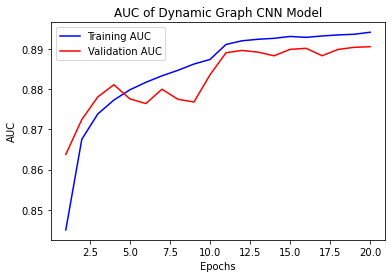

In [18]:
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history.history['auc'], color='green', label='Training AUC')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history.history['val_auc'], color='red', label='Validation AUC')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title("AUC of Dynamic Graph CNN Model")
plt.legend()
plt.show()

### Accuracy

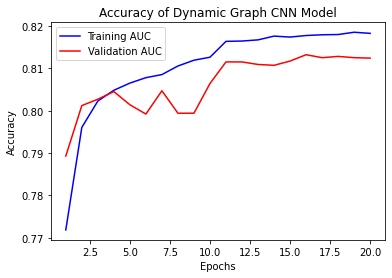

In [22]:
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history.history['accuracy'], color='green', label='Training AUC')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history.history['val_accuracy'], color='red', label='Validation AUC')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy of Dynamic Graph CNN Model")
plt.legend()
plt.show()

### Loss 

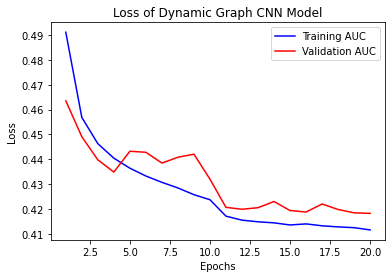

In [23]:
 plt.plot(np.linspace(1,epochs,epochs, dtype=int), history.history['loss'], color='green     ', label='Training AUC')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history.history['val_loss'], color='red', label='Validation AUC')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss of Dynamic Graph CNN Model")
plt.legend()
plt.show()

## Evaluation

In [21]:
loss, acc, auc = model_lite_static.evaluate(test_dict, y_test)
print("Evaluation Metric of Dynamic Graph CNN Model on Test Dataset")
print("Loss:", loss)
print("Accuracy:", acc)
print("AUC:", auc)


313/313 [==============================] - 10s 32ms/step - loss: 0.4192 - accuracy: 0.8115 - auc: 0.8899
Evaluation Metric of Dynamic Graph CNN Model on Test Dataset
Loss: 0.41921645402908325
Accuracy: 0.8115000128746033
AUC: 0.8898574113845825


# Results & Conclusion


In [45]:
# rows = 
columns = ['Train', 'Validation', 'Test']
Metrics = ['Accuracy', 'AUC', 'Loss']
dynamic_results={
                'Train':['0.8153','0.8910','0.4175'],
                'Validation':['0.8095','0.8862','0.4264'],
                'Test':['0.8119','0.8858','0.4261']}
static_results={'Train':['0.8182','0.8942','0.4116'],
               'Validation':['0.8124','0.8096','0.4183'],
               'Test':['0.8115','0.8899','0.4192']}

results_dynamic=pd.DataFrame(dynamic_results,index=Metrics)
results_static=pd.DataFrame(static_results,index=Metrics)
print('ParticleNet Lite (Dynamic)')
print(results_dynamic)
print('ParticleNet Lite (Static)')
print(results_static)

ParticleNet Lite (Dynamic)
           Train Validation    Test
Accuracy  0.8153     0.8095  0.8119
AUC       0.8910     0.8862  0.8858
Loss      0.4175     0.4264  0.4261
ParticleNet Lite (Static)
           Train Validation    Test
Accuracy  0.8182     0.8124  0.8115
AUC       0.8942     0.8096  0.8899
Loss      0.4116     0.4183  0.4192


From the above results, we can say that
<ul>
    <li>It is not appropriate to consider the overall training time as a metric for superiority because we use a small number of data samples here, also both models train in almost similar time. However, there is a difference of ~12 seconds in the time/epoch for each model, but I found that there is a high variance in times required for each epoch. This maybe because of the hardware.</li>
    <li>The static model gives better performance on the training dataset which also signals that there is not much gain due to the dynamic update operation and the model would give same or better performance even without the operation. </li>
    <li>Also the loss incurred is less for the static model in all three divisions(train,validation,test)</li>
    <li>From the graphs plotted, it is observed that the validation curve shows unstabiliies for both models which may be attributed to the short size of the dataset.</li><br>
    <br><i>Overall, the ParticleNet (static) model performs better than the dynamic model.</i>

# References
[1]-[Y. Wang, Y. Sun, Z. Liu, S. E. Sarma, M. M. Bronstein,and J. M. Solomon, “Dynamic graph cnn for learning on point clouds,”](https://arxiv.org/abs/1801.07829)<br>
[2]-[H. Qu and L. Gouskos, “Jet tagging via particle clouds,” Phys. Rev. D, vol. 101, no. 5, p. 056019, Mar. 2020.](https://arxiv.org/abs/1902.08570)<br>
[3]-[Vinicius Mikuni and Florencia Canelli. Abcnet: An attention-based method for particle tagging,
2020](https://arxiv.org/abs/2001.05311)<br>
[4]-[I. Henrion, J. Brehmer, J. Bruna, K. Cho, K. Cranmer,G. Louppe, and G. Rochette, “Neural Message Passingfor Jet Physics,” in Deep Learning for Physical Sciences Workshop at the 31st Conference on Neural InformationProcessing Systems (NIPS) (2017).](https://dl4physicalsciences.github.io/files/nips_dlps_2017_29.pdf)